In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

In [2]:
df1 = pd.read_csv("data/야수_전처리_ver12.csv")
df2 = pd.read_csv("data/2026_FA예정_타자.csv")

In [3]:
# 계약금 컬럼 생성
df1['FA 계약 총액'] = df1['FA 계약 총액'].fillna(0)
df1['연봉'] = df1['연봉'].fillna(0)
df1['계약금'] = df1['FA 계약 총액'] + df1['연봉']

In [4]:
# 전처리 함수 정의
def preprocess(df):
    df = df.copy()

    # 조건 필터링
    if '구분' in df.columns:
        df = df[~df['구분'].isin(['해외', 'FA 1년차'])]
    if 'FA등급' in df.columns:
        df = df[~df['FA등급'].isin(['해외', 'FA 1년차'])]
    if '플레이년도' in df.columns:
        df = df[df['플레이년도'] > 2015]

    # 컬럼 제거
    drop_cols = ['선수명_수정', 'FA 계약 총액', '연봉', '잔류여부']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    # 선수명 기준 평균 후 중복 제거
    df = df.groupby('선수명', as_index=False).mean(numeric_only=True)

    return df

# 전처리 적용
df1_cleaned = preprocess(df1)
df2_cleaned = preprocess(df2)

C:\Users\Lee\AppData\Local\Temp\ipykernel_11280\1914192553.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')


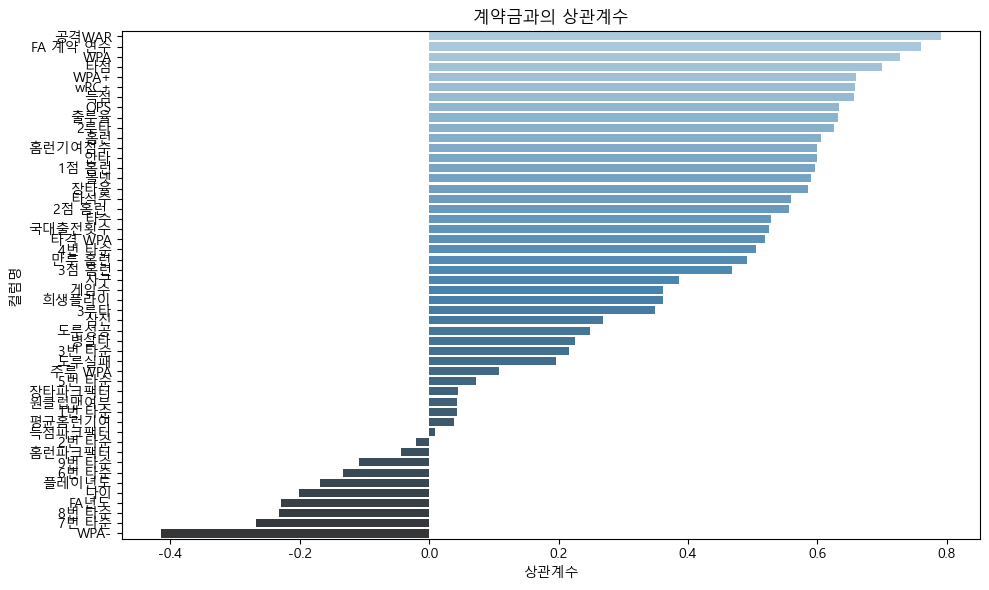

In [5]:
# 계약금과의 상관계수 계산
correlations = df1_cleaned.corr(numeric_only=True)['계약금'].drop('계약금').sort_values(ascending=False)


# 한글 시각화 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 상관계수 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')
plt.title('계약금과의 상관계수')
plt.xlabel('상관계수')
plt.ylabel('컬럼명')
plt.tight_layout()
plt.show()

In [6]:
# 상관계수 기반 가중치 계산
weights = correlations.abs() / correlations.abs().sum()
weight_df = pd.DataFrame({'컬럼명': weights.index, '가중치': weights.values})
print("상관계수 기반 가중치:")
print(weight_df)

# 예측에 사용할 공통 피처 추출
predict_features = [f for f in weights.index if f in df1_cleaned.columns and f in df2_cleaned.columns]
print(f"예측에 사용될 공통 피처: {predict_features}")

상관계수 기반 가중치:
         컬럼명       가중치
0      공격WAR  0.040855
1   FA 계약 연수  0.039275
2        WPA  0.037568
3         타점  0.036160
4       WPA+  0.034056
5       wRC+  0.033973
6         득점  0.033944
7        OPS  0.032738
8        출루율  0.032661
9        2루타  0.032353
10        홈런  0.031318
11    홈런기여점수  0.030976
12        안타  0.030939
13     1점 홈런  0.030799
14        볼넷  0.030449
15       장타율  0.030230
16       타석수  0.028906
17    2점 홈런   0.028724
18        타수  0.027303
19    국대출전횟수  0.027093
20    타격 WPA  0.026799
21     4번 타순  0.026125
22     만루 홈런  0.025381
23     3점 홈런  0.024150
24        사구  0.019909
25       게임수  0.018696
26     희생플라이  0.018636
27       3루타  0.018032
28        삼진  0.013870
29      도루성공  0.012825
30       병살타  0.011638
31     3번 타순  0.011183
32      도루실패  0.010136
33    주루 WPA  0.005569
34     5번 타순  0.003776
35    장타파크팩터  0.002330
36    원클럽맨여부  0.002259
37     1번 타순  0.002211
38    평균홈런기여  0.001993
39    득점파크팩터  0.000481
40     2번 타순  0.001028
41    홈런파크팩터  0.00222

In [7]:
# 데이터 준비
X = df1_cleaned[predict_features]
y = df1_cleaned['계약금']
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy[predict_features]
y = Xy['계약금']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(df2_cleaned[predict_features])

In [8]:
# CatBoost + GridSearchCV
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.1],
    'iterations': [200, 500]
}

cat_model = CatBoostRegressor(
    verbose=0,
    random_state=42
)

grid = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_scaled, y_train)
best_model = grid.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [9]:
# 성능 확인
val_pred = best_model.predict(X_val_scaled)
rmse = mean_squared_error(y_val, val_pred, squared=False)
print(f"[CatBoost + GridSearchCV] 검증 RMSE: {rmse:,.2f}")
print("최적 하이퍼파라미터:", grid.best_params_)

# 예측 결과
df2_cleaned['계약금'] = best_model.predict(X_test_scaled)

[CatBoost + GridSearchCV] 검증 RMSE: 162,208.27
최적 하이퍼파라미터: {'depth': 4, 'iterations': 500, 'learning_rate': 0.03}


C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


C:\Users\Lee\AppData\Local\Temp\ipykernel_11280\2977306896.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='중요도 (CatBoost)', y='컬럼명', palette='YlGn_r')


피처 중요도 (CatBoost):
       컬럼명  중요도 (CatBoost)  상관계수 기반 가중치
17  국대출전횟수       20.319316     0.027093
0    공격WAR       12.604389     0.040855
4     wRC+        5.827629     0.033973
42      나이        4.934561     0.010384
5       득점        4.907859     0.033944
7      출루율        4.198615     0.032661
2       타점        2.767843     0.036160
1      WPA        2.512277     0.037568
38  홈런파크팩터        2.399391     0.002225
6      OPS        2.355293     0.032738
8      2루타        2.310091     0.032353
22      사구        2.255478     0.019909
26      삼진        2.094713     0.013870
14     장타율        1.964443     0.030230
25     3루타        1.832359     0.018032
15     타석수        1.831878     0.028906
12   1점 홈런        1.452121     0.030799
37   2번 타순        1.391244     0.001028
27    도루성공        1.326296     0.012825
13      볼넷        1.249427     0.030449
24   희생플라이        1.235053     0.018636
16      타수        1.131751     0.027303
29   3번 타순        1.077494     0.011183
36  득점파크팩터        1.0

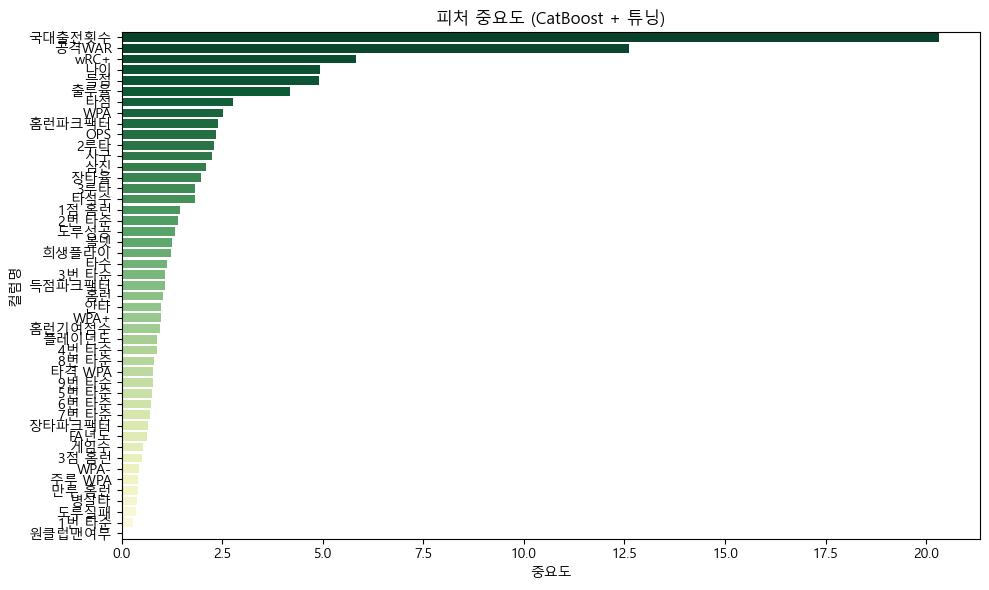

In [10]:
# 피처 중요도 정리
importance_df = pd.DataFrame({
    '컬럼명': predict_features,
    '중요도 (CatBoost)': best_model.feature_importances_,
    '상관계수 기반 가중치': [weights[f] for f in predict_features]
}).sort_values(by='중요도 (CatBoost)', ascending=False)

print("피처 중요도 (CatBoost):")
print(importance_df)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='중요도 (CatBoost)', y='컬럼명', palette='YlGn_r')
plt.title('피처 중요도 (CatBoost + 튜닝)')
plt.xlabel('중요도')
plt.tight_layout()
plt.show()

In [11]:
# 예측 결과 출력
print("예측 계약금 상위 선수:")
print(df2_cleaned[['선수명', '계약금']].sort_values(by='계약금', ascending=False))

예측 계약금 상위 선수:
    선수명            계약금
0   강민호  215553.722308
2   김재환  214715.703077
6   박해민  190143.383747
3   박병호  187209.511067
13  최형우  186593.255752
5   박찬호  173000.840295
7   손아섭  154719.268471
1   강백호  154230.623916
12  최원준  146432.253958
14  황재균  146365.750631
9   장성우  120762.480462
8   이재원   77744.109120
11  조수행   50937.880813
4   박승욱   48616.375027
10   정훈   21173.304636
